<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully fetched SNIPS dataset
Total intents: 10
Example intent: ShareCurrentLocation
Example queries: ["Share my location with Hillary's sister", 'Send my current location to my father', 'Share my current location with Jim', 'Send my location to my husband', 'Send my location']
Total samples: 328
Vocabulary size: 110
Intent labels mapping: {'BookRestaurant': 0, 'ComparePlaces': 1, 'GetDirections': 2, 'GetPlaceDetails': 3, 'GetTrafficInformation': 4, 'GetWeather': 5, 'RequestRide': 6, 'SearchPlace': 7, 'ShareCurrentLocation': 8, 'ShareETA': 9}
Epoch 01: Train Loss = 2.2556, Train Acc = 20.99%
Epoch 02: Train Loss = 2.1030, Train Acc = 35.11%
Epoch 03: Train Loss = 1.9111, Train Acc = 37.79%
Epoch 04: Train Loss = 1.6661, Train Acc = 43.51%
Epoch 05: Train Loss = 1.4802, Train Acc = 50.76%
Epoch 06: Train Loss = 1.3393, Train Acc = 59.54%
Epoch 07: Train Loss = 1.1197, Train Acc = 66.03%
Epoch 08: Train Loss = 0.9201, Train Acc = 72.52%
Epoch 09: Train Loss = 0.7763, Train Acc = 80.

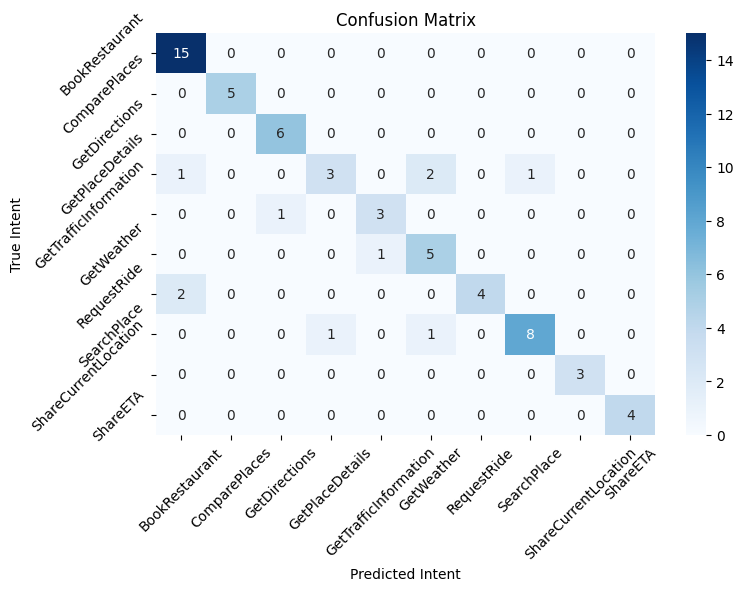

Query: tensor([62,  1, 71, 49, 45,  1, 57, 42,  1]) | True: RequestRide, Predicted: BookRestaurant
Query: tensor([48, 49,  1, 27,  1]) | True: SearchPlace, Predicted: GetWeather
Query: tensor([63, 56,  1, 12,  1, 57,  1,  1,  1]) | True: GetPlaceDetails, Predicted: BookRestaurant
Query: tensor([48, 49,  1, 50,  1,  1]) | True: GetPlaceDetails, Predicted: GetWeather
Query: tensor([55, 49,  1,  1, 37,  1]) | True: GetPlaceDetails, Predicted: SearchPlace
Query: tensor([61, 62,  9,  1, 15, 21,  1, 37,  1]) | True: SearchPlace, Predicted: GetPlaceDetails
Query: tensor([44, 31, 54, 15,  1, 57, 64,  1,  1]) | True: GetPlaceDetails, Predicted: GetWeather
Query: tensor([73,  1,  8,  1,  8, 36,  8,  3,  1, 30]) | True: GetTrafficInformation, Predicted: GetDirections
Query: tensor([106,   9, 105,  92,   1,   8,   1,   8,   3,   1]) | True: GetWeather, Predicted: GetTrafficInformation
Query: tensor([82, 49, 45,  1, 57,  3,  7,  4]) | True: RequestRide, Predicted: BookRestaurant


In [18]:
import requests
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------------------------
# 1. Fetch and Process the SNIPS Dataset
# ----------------------------
url = "https://raw.githubusercontent.com/snipsco/nlu-benchmark/master/2016-12-built-in-intents/benchmark_data.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print("Successfully fetched SNIPS dataset")

    # Extract intents and associated text queries
    snips_data = {}
    for domain in data["domains"]:
        for intent in domain["intents"]:
            intent_name = intent["benchmark"]["Snips"]["original_intent_name"]
            queries = [query["text"] for query in intent["queries"]]
            if intent_name in snips_data:
                snips_data[intent_name].extend(queries)
            else:
                snips_data[intent_name] = queries

    print(f"Total intents: {len(snips_data)}")
    example_intent = list(snips_data.keys())[0]
    print("Example intent:", example_intent)
    print("Example queries:", snips_data[example_intent][:5])
else:
    raise Exception("Failed to fetch SNIPS dataset")

# Convert the dictionary into a list of (query, intent) pairs.
data_samples = []
for intent, queries in snips_data.items():
    for query in queries:
        data_samples.append((query, intent))
print(f"Total samples: {len(data_samples)}")

# ----------------------------
# 2. Build the Vocabulary and Label Mappings
# ----------------------------
def build_vocab(data, min_freq=1):
    from collections import Counter
    counter = Counter()
    for sentence, _ in data:
        tokens = sentence.lower().split()
        counter.update(tokens)
    # Reserve 0 for padding and 1 for unknown tokens.
    vocab = {"<pad>": 0, "<unk>": 1}
    idx = 2
    for token, count in counter.items():
        if count >= min_freq:
            vocab[token] = idx
            idx += 1
    return vocab

vocab = build_vocab(data_samples, min_freq=5)
print("Vocabulary size:", len(vocab))

# Build label mappings.
intent_names = sorted({intent for _, intent in data_samples})
label2idx = {label: i for i, label in enumerate(intent_names)}
idx2label = {i: label for label, i in label2idx.items()}
print("Intent labels mapping:", label2idx)

# ----------------------------
# 3. Define the PyTorch Dataset and Collate Function
# ----------------------------
class SnipsDataset(Dataset):
    def __init__(self, data, vocab, label2idx):
        self.data = data
        self.vocab = vocab
        self.label2idx = label2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        query, intent = self.data[idx]
        tokens = query.lower().split()
        token_ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
        return torch.tensor(token_ids, dtype=torch.long), self.label2idx[intent]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=vocab["<pad>"])
    return padded, torch.tensor(labels, dtype=torch.long), lengths

# Instantiate and split the dataset (80% training, 20% test)
dataset = SnipsDataset(data_samples, vocab, label2idx)
num_samples = len(dataset)
num_train = int(0.8 * num_samples)
num_test = num_samples - num_train
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_test])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ----------------------------
# 4. Define the RNN Model with Dropout
# ----------------------------
'''class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 num_layers=1, bidirectional=True, dropout=0.3):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab["<pad>"])
        # Note: In PyTorch, the built-in dropout in RNNs is applied only when num_layers > 1.
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=bidirectional, batch_first=True,
                          dropout=dropout if num_layers > 1 else 0)
        fc_in_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_in_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    def forward(self, x, lengths):
        # x: (B, T)
        embedded = self.embedding(x)  # (B, T, embedding_dim)
        embedded = self.dropout(embedded)  # Apply dropout to embeddings
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                            batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # Retrieve the final hidden state
        if self.bidirectional:
            # hidden shape: (num_layers * 2, B, hidden_dim)
            hidden = hidden.view(self.num_layers, 2, x.size(0), self.hidden_dim)
            hidden_last = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1)
        else:
            # hidden shape: (num_layers, B, hidden_dim)
            hidden_last = hidden[-1]
        hidden_last = self.dropout(hidden_last)  # Apply dropout before final layer
        output = self.fc(hidden_last)
        return output'''

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 num_layers=1, bidirectional=True, dropout=0.3):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab["<pad>"])
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           bidirectional=bidirectional, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)
        fc_in_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_in_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        # Store hidden_dim and num_layers as attributes of the RNNClassifier
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x, lengths):
        # Embed input tokens
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)

        # Pack the embedded sequence for LSTM
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                            batch_first=True, enforce_sorted=False)
        # Pass through LSTM
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        # Get the final hidden state
        if self.rnn.bidirectional:
            # Use self.hidden_dim and self.num_layers instead of self.rnn.hidden_dim and self.rnn.num_layers
            hidden = hidden.view(self.num_layers, 2, x.size(0), self.hidden_dim)
            hidden_last = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1)
        else:
            hidden_last = hidden[-1]

        # Apply dropout and fully connected layer
        hidden_last = self.dropout(hidden_last)
        output = self.fc(hidden_last)
        return output

# Hyperparameters
embedding_dim = 50
hidden_dim = 128
output_dim = len(label2idx)
num_layers = 1         # Increase this if desired
bidirectional = True # Change to True to use a bidirectional RNN
dropout = 0.3

model = RNNClassifier(vocab_size=len(vocab),
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      output_dim=output_dim,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      dropout=dropout)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ----------------------------
# 5. Train the Model (with Weight Decay) and Evaluate After Training
# ----------------------------
# Use weight decay for L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 15
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        x, y, lengths = batch
        x, y, lengths = x.to(device), y.to(device), lengths.to(device)
        optimizer.zero_grad()
        outputs = model(x, lengths)  # (B, output_dim)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    train_loss = epoch_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc*100:.2f}%")

# ----------------------------
# 6. Evaluate the Model on the Test Set (After Training)
# ----------------------------
model.eval()
test_loss = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y, lengths = batch
        x, y, lengths = x.to(device), y.to(device), lengths.to(device)
        outputs = model(x, lengths)
        loss = criterion(outputs, y)
        test_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y.cpu().numpy())

test_loss /= len(test_loader)
test_acc = accuracy_score(all_test_labels, all_test_preds)
print(f"\nFinal Test Loss = {test_loss:.4f}, Test Acc = {test_acc*100:.2f}%")

# ----------------------------
# 7. Additional Evaluation: Classification Report and Confusion Matrix
# ----------------------------
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=intent_names))

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=intent_names, yticklabels=intent_names)
plt.xlabel("Predicted Intent")
plt.ylabel("True Intent")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

for i, (true, pred) in enumerate(zip(all_test_labels, all_test_preds)):
    if true != pred:
        print(f"Query: {test_dataset[i][0]} | True: {idx2label[true]}, Predicted: {idx2label[pred]}")
